# Betweenness and Weighted-Betweenness Centrality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict
import networkx as nx
import itertools

### Step 1. Subway Stations and Passenger Flows

Since station codes depend on the subway lines, one-to-many relationship exists between station names and codes due to transfer.

In [3]:
df_station = pd.read_csv("Station.csv")
print(df_station.head())

   Code                         Name
0  A000                        Seoul
1  A001                     Gongdeok
2  A002            Hongik University
3  A003           Digital Media City
4  A004  Gimpo International Airport


In [4]:
code_to_name = df_station.set_index("Code").to_dict(orient="dict")["Name"]

In [5]:
print(code_to_name["A000"])

Seoul


In [6]:
name_to_code = defaultdict(list)
for i in range(len(df_station)):
    name_to_code[str(df_station["Name"][i])].append(str(df_station["Code"][i]))

In [7]:
print(name_to_code["Seoul"])

['A000', 'G102', '1033', '4017']


In [8]:
df_flow = pd.read_csv("Flow.csv")
print(df_flow.head())

      From              To  Flow
0  Achasan          Aeogae   874
1  Achasan          Ahyeon   205
2  Achasan  Airport Market    31
3  Achasan            Amsa  4909
4  Achasan            Anam   511


In [9]:
flows = df_flow.set_index(["From", "To"]).to_dict(orient="dict")["Flow"]

In [10]:
print(flows[("Achasan", "Aeogae")])

874


### Step 2. Construct Subway Network

A subway system consists of a set of stations and a set of directly connected links between every two adjacent stations. Here, in order to seek out the shortest paths while reflecting transfer times, station codes rather than names are used. The links are weighted by traveling times and 2 minutes which is the average of the known transfer times has been applied throughout the network.

In [11]:
df_time = pd.read_csv("Time.csv")
print(df_time.head())

   From    To  Time
0  A000  A001   4.0
1  A001  A002   5.0
2  A002  A003   3.5
3  A003  A004   9.5
4  A004  A005   6.5


In [12]:
subway_network = list(df_time.itertuples(index=False, name=None))

In [13]:
print(subway_network[0])

('A000', 'A001', 4.0)


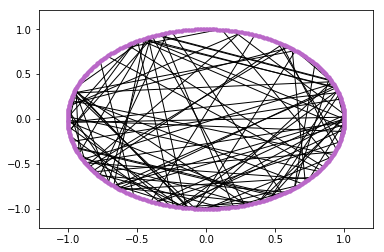

In [14]:
graph = nx.Graph()
graph.add_weighted_edges_from(subway_network)
nx.draw_networkx(graph, node_size=10, node_color="#BA68C8", with_labels=False,
                 pos=nx.circular_layout(graph)); plt.show()

### Step 3. Find All Pairs of Shortest Paths

After searching for the shortest paths, station codes in each route are converted to station names so as to compute betweenness centrality. Note that a source-target combination (S, T) can have more than one shortest path.

In [15]:
shortest_paths = {}
for (S, T) in list(itertools.permutations(name_to_code, 2)):
    ST_time, ST_path = (float("inf"), [])
    for s in name_to_code[S]:
        for t in name_to_code[T]:
            time = nx.shortest_path_length(graph, source=s, target=t, weight="weight")
            if time<ST_time:
                ST_time = time; ST_path[:] = []
                for path in nx.all_shortest_paths(graph, source=s, target=t, weight="weight"):
                    ST_path.append(path)    
            elif time==ST_time:
                for path in nx.all_shortest_paths(graph, source=s, target=t, weight="weight"):
                    ST_path.append(path)           
    for i in range(len(ST_path)):
        for j in range(len(ST_path[i])):
            ST_path[i][j] = code_to_name[ST_path[i][j]]
    shortest_paths[(S, T)] = list(set([tuple(path) for path in ST_path]))

In [16]:
print(shortest_paths[("Seoul", "Pangyo")])

[('Seoul', 'Hoehyeon', 'Myeongdong', 'Chungmuro', 'Chungmuro', 'Dongguk University', 'Yaksu', 'Geumho', 'Oksu', 'Apgujeong', 'Sinsa', 'Jamwon', 'Express Bus Terminal', 'Seoul National University of Education', 'Nambu Bus Terminal', 'Yangjae', 'Yangjae', "Yangjae Citizen's Forest", 'Cheonggyesan', 'Pangyo'), ('Seoul', "Sookmyung Women's University", 'Samgakji', 'Sinyongsan', 'Ichon', 'Dongjak', 'Chongshin University', 'Sadang', 'Sadang', 'Bangbae', 'Seocho', 'Seoul National University of Education', 'Gangnam', 'Gangnam', 'Yangjae', "Yangjae Citizen's Forest", 'Cheonggyesan', 'Pangyo')]


### Step 4. Calculate Betweenness Centrality

The value of betweenness centrality means how frequently the node appears on the shortest paths, working as a central point in the network in terms of intermediation. Whereas betweenness centrality considers every route to have the same weight, weighted-betweenness centrality gives each count different weight depending on the size of passenger flow.

In [17]:
betweenness_centrality = {}
for V in name_to_code.keys():
    bc = 0; wbc = 0
    for (S, T) in shortest_paths.keys():
        if V not in (S, T):
            count = 0
            for i in range(len(shortest_paths[(S, T)])):
                if V in shortest_paths[(S, T)][i]:
                    count += 1
            bc += count/len(shortest_paths[(S, T)])
            wbc += (count/len(shortest_paths[(S, T)]))*flows[(S, T)]
    betweenness_centrality[V] = (bc, wbc)

In [18]:
result = pd.DataFrame.from_dict(betweenness_centrality, orient="index")
result = result.rename(columns={0:"BC", 1:"WBC"}).sort_index(axis=0)
print(result.head())

                          BC           WBC
Achasan          8921.766667  4.830661e+06
Aeogae           3779.533333  2.819010e+06
Ahyeon          17994.652381  8.368261e+06
Airport Market   2661.000000  5.380115e+05
Amsa                0.000000  0.000000e+00


In [19]:
result["BC"] = result["BC"]/len(df_flow["Flow"])
result["WBC"] = result["WBC"]/df_flow["Flow"].sum()
print(result.head())

                      BC       WBC
Achasan         0.036782  0.024829
Aeogae          0.015582  0.014490
Ahyeon          0.074188  0.043013
Airport Market  0.010971  0.002765
Amsa            0.000000  0.000000


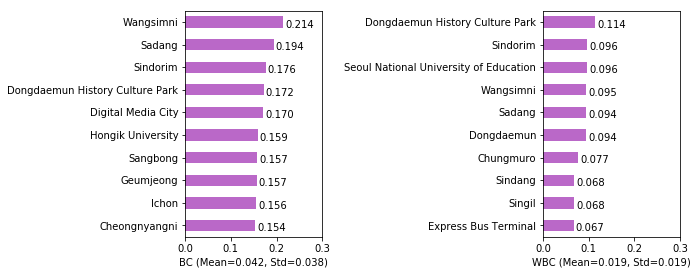

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax1 = result.sort_values(by="BC")["BC"][-10:].plot(kind="barh", color="#BA68C8")
for p in ax1.patches:
    ax1.annotate("%.3f" % p.get_width(), (p.get_x()+p.get_width(), p.get_y()),
                 xytext=(2, 0), textcoords="offset points")
plt.xlim((0, 0.3)); plt.tight_layout(rect=(0.01, 0.01, 0.99, 0.99))
plt.xlabel("BC (Mean=%.3f, Std=%.3f)" % (result["BC"].mean(), result["BC"].std()))
plt.subplot(1, 2, 2)
ax2 = result.sort_values(by="WBC")["WBC"][-10:].plot(kind="barh", color="#BA68C8")
for p in ax2.patches:
    ax2.annotate("%.3f" % p.get_width(), (p.get_x()+p.get_width(), p.get_y()),
                 xytext=(2, 0), textcoords="offset points")
plt.xlim((0, 0.3)); plt.tight_layout(rect=(0.01, 0.01, 0.99, 0.99))
plt.xlabel("WBC (Mean=%.3f, Std=%.3f)" % (result["WBC"].mean(), result["WBC"].std()))
plt.show()